In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import statsmodels.api as sm
import seaborn as sns
from sklearn.neighbors import KernelDensity
from PIL import Image

/Users/shu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/shu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


ImportError: cannot import name '_centered' from 'scipy.signal.signaltools' (/Users/shu/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/signaltools.py)

In [ ]:
import matplotlib as mpl
mpl.rc("figure", dpi=100)

In [117]:
df = pd.read_csv('data.tsv', sep='\t')

In [118]:
df = df[df['Fixation point X'].notna()]

In [119]:
task1_img = mpimg.imread('Task1.png') 
task2_img = mpimg.imread('Task2.png') 

In [120]:
current_img = task1_img

In [121]:
screenWidth = 1920
screenHeight = 1080
imageWidth = task1_img.shape[1]
imageHeight = task1_img.shape[0]
scaledImageWidth = screenWidth
scaledImageHeight = (imageHeight / imageWidth) * scaledImageWidth
heightReduce = (screenHeight - scaledImageHeight) / 2
lineY = screenHeight / 2

In [122]:
heatmap_data = df.loc[df["Eye movement type"] == "Fixation"]
heatmap_data = df.loc[df["Sensor"] == "Eye Tracker"]
heatmap_data["Gaze event duration"] = heatmap_data["Gaze event duration"].apply(lambda x: x**2)
maxy = heatmap_data["Fixation point Y"].max()

# Rotate PointY on X-Axis
heatmap_data["Fixation point Y"] = heatmap_data["Fixation point Y"].apply(lambda y: y - (y-lineY)*2)

# Reduce rest height of image since its centralized on tobii on screen
heatmap_data["Fixation point Y"] = heatmap_data["Fixation point Y"].apply(lambda y: y - heightReduce)

# Remove points outside of image
heatmap_data = heatmap_data.loc[(heatmap_data["Fixation point X"] <= scaledImageWidth) & (heatmap_data["Fixation point X"] >= 0)]
heatmap_data = heatmap_data.loc[(heatmap_data["Fixation point Y"] <= scaledImageHeight) & (heatmap_data["Fixation point Y"] >= 0)]

# save pandas to csv
heatmap_data.to_csv('fixation_data.csv', index=False)

# load csv to pandas
heatmap_data = pd.read_csv('fixation_data.csv')
heatmap_data = heatmap_data.loc[heatmap_data["Presented Stimulus name"] == "Task1 (1)"]

/tmp/ipykernel_1611059/2675791168.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data["Gaze event duration"] = heatmap_data["Gaze event duration"].apply(lambda x: x**2)
/tmp/ipykernel_1611059/2675791168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data["Fixation point Y"] = heatmap_data["Fixation point Y"].apply(lambda y: y - (y-lineY)*2)
/tmp/ipykernel_1611059/2675791168.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [123]:
x = heatmap_data["Fixation point X"].to_list()
y = heatmap_data["Fixation point Y"].to_list()

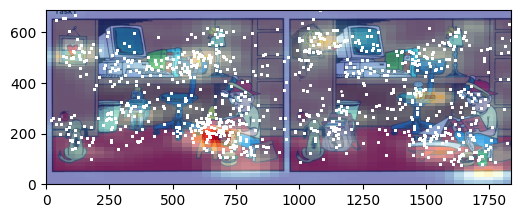

In [126]:
plt.xlim([0, max(x)])
plt.ylim([0, max(y)])
ext = [0, scaledImageWidth, 0, scaledImageHeight]
plt.imshow(task1_img, zorder=0, extent=ext)

xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
values = np.vstack([x, y])

# Gaussian KDE.
kernel = st.gaussian_kde(values, bw_method=.1)
# Grid density (number of points).
gd_c = complex(0, 50)
# Define x,y grid.
x_grid, y_grid = np.mgrid[xmin:xmax:gd_c, ymin:ymax:gd_c]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
# Evaluate kernel in grid positions.
k_pos = kernel(positions)

kde = np.reshape(k_pos.T, x_grid.shape)
im = plt.imshow(np.rot90(kde), cmap=plt.get_cmap('RdYlBu_r'), extent=ext, zorder=1, alpha=0.6)
plt.scatter(x, y, s=1, zorder=2, color='white')
# todo -> duration weight